##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [2]:
!pip install remotezip tqdm opencv-python einops 
!pip install -U tensorflow keras

In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [2]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir
  print(f'dirs = {dirs}')
  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
# URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
# download_dir = pathlib.Path('./subset/')
# subset_paths = download_ufc_101_subset(URL, 
#                         num_classes = 10, 
#                         splits = {"train": 30, "val": 10, "test": 10},
#                         download_dir = download_dir)
pathdir = 'videoclass'
subset_paths = {'train': pathlib.Path(f'{pathdir}/train'), 'val': pathlib.Path(f'{pathdir}/val'), 'test': pathlib.Path(f'{pathdir}/test')}
print(f'subset_paths = {subset_paths}')

subset_paths = {'train': WindowsPath('videoclass/train'), 'val': WindowsPath('videoclass/val'), 'test': WindowsPath('videoclass/test')}


 51%|█████▏    | 154/300 [00:17<00:28,  5.20it/s]

 52%|█████▏    | 155/300 [00:18<00:27,  5.33it/s]

 52%|█████▏    | 156/300 [00:18<00:30,  4.73it/s]

 52%|█████▏    | 157/300 [00:18<00:30,  4.69it/s]

 53%|█████▎    | 158/300 [00:18<00:30,  4.64it/s]

 53%|█████▎    | 160/300 [00:19<00:30,  4.66it/s]

 54%|█████▎    | 161/300 [00:19<00:30,  4.52it/s]

 54%|█████▍    | 163/300 [00:19<00:22,  6.07it/s]

 55%|█████▍    | 164/300 [00:20<00:27,  4.98it/s]

 55%|█████▌    | 166/300 [00:20<00:20,  6.65it/s]

 56%|█████▌    | 167/300 [00:20<00:21,  6.32it/s]

 56%|█████▋    | 169/300 [00:20<00:17,  7.58it/s]

 57%|█████▋    | 170/300 [00:20<00:16,  7.84it/s]

 57%|█████▋    | 171/300 [00:20<00:16,  7.64it/s]

 57%|█████▋    | 172/300 [00:20<00:16,  7.89it/s]

 58%|█████▊    | 173/300 [00:21<00:21,  5.95it/s]

 58%|█████▊    | 174/300 [00:21<00:23,  5.35it/s]

 58%|█████▊    | 175/300 [00:21<00:26,  4.64it/s]

 59%|█████▊    | 176/300 [00:21<00:24,  5.15it/s]

 59%|█████▉    | 178/300 [00:22<00:17,  6.99it/s]

 60%|█████▉    | 179/300 [00:22<00:21,  5.54it/s]

 60%|██████    | 181/300 [00:22<00:18,  6.44it/s]

 61%|██████    | 182/300 [00:22<00:24,  4.87it/s]

 61%|██████    | 183/300 [00:23<00:21,  5.39it/s]

 61%|██████▏   | 184/300 [00:23<00:19,  6.02it/s]

 62%|██████▏   | 185/300 [00:23<00:19,  5.95it/s]

 62%|██████▏   | 186/300 [00:23<00:18,  6.11it/s]

 63%|██████▎   | 188/300 [00:23<00:14,  7.54it/s]

 63%|██████▎   | 189/300 [00:23<00:14,  7.73it/s]

 63%|██████▎   | 190/300 [00:23<00:14,  7.79it/s]

 64%|██████▎   | 191/300 [00:24<00:13,  7.95it/s]

 64%|██████▍   | 192/300 [00:24<00:13,  7.95it/s]

 65%|██████▍   | 194/300 [00:24<00:12,  8.26it/s]

 65%|██████▌   | 196/300 [00:24<00:10,  9.97it/s]

 66%|██████▌   | 198/300 [00:24<00:10,  9.80it/s]

 67%|██████▋   | 200/300 [00:24<00:09, 10.96it/s]

 67%|██████▋   | 202/300 [00:24<00:07, 12.43it/s]

 68%|██████▊   | 204/300 [00:25<00:07, 12.57it/s]

 69%|██████▊   | 206/300 [00:25<00:07, 12.44it/s]

 69%|██████▉   | 208/300 [00:25<00:07, 12.71it/s]

 70%|███████   | 210/300 [00:25<00:07, 11.74it/s]

 71%|███████   | 212/300 [00:25<00:09,  9.43it/s]

 71%|███████▏  | 214/300 [00:26<00:09,  8.83it/s]

 72%|███████▏  | 216/300 [00:26<00:08,  9.90it/s]

 73%|███████▎  | 218/300 [00:26<00:08,  9.52it/s]

 73%|███████▎  | 220/300 [00:26<00:07, 10.44it/s]

 74%|███████▍  | 222/300 [00:26<00:07, 11.10it/s]

 75%|███████▍  | 224/300 [00:27<00:06, 11.84it/s]

 75%|███████▌  | 226/300 [00:27<00:06, 11.33it/s]

 76%|███████▌  | 228/300 [00:27<00:06, 11.21it/s]

 77%|███████▋  | 230/300 [00:27<00:05, 12.00it/s]

 77%|███████▋  | 232/300 [00:27<00:06, 11.27it/s]

 78%|███████▊  | 234/300 [00:27<00:05, 11.91it/s]

 79%|███████▊  | 236/300 [00:28<00:04, 13.05it/s]

 79%|███████▉  | 238/300 [00:28<00:04, 13.13it/s]

 80%|████████  | 240/300 [00:28<00:04, 13.46it/s]

 81%|████████  | 242/300 [00:28<00:05,  9.83it/s]

 81%|████████▏ | 244/300 [00:28<00:06,  8.38it/s]

 82%|████████▏ | 246/300 [00:29<00:05,  9.65it/s]

 83%|████████▎ | 248/300 [00:29<00:06,  8.38it/s]

 83%|████████▎ | 250/300 [00:29<00:05,  9.57it/s]

 84%|████████▍ | 252/300 [00:29<00:04,  9.85it/s]

 85%|████████▍ | 254/300 [00:29<00:04,  9.22it/s]

 85%|████████▌ | 256/300 [00:30<00:04, 10.38it/s]

 86%|████████▌ | 258/300 [00:30<00:04,  9.39it/s]

 87%|████████▋ | 260/300 [00:30<00:03, 10.76it/s]

 87%|████████▋ | 262/300 [00:30<00:03, 12.11it/s]

 88%|████████▊ | 264/300 [00:30<00:03, 11.57it/s]

 89%|████████▊ | 266/300 [00:31<00:03, 10.12it/s]

 89%|████████▉ | 268/300 [00:31<00:02, 11.00it/s]

 90%|█████████ | 270/300 [00:31<00:03,  9.42it/s]

 91%|█████████ | 272/300 [00:31<00:03,  7.06it/s]

 91%|█████████ | 273/300 [00:32<00:03,  6.98it/s]

 91%|█████████▏| 274/300 [00:32<00:04,  6.29it/s]

 92%|█████████▏| 275/300 [00:32<00:03,  6.45it/s]

 92%|█████████▏| 277/300 [00:33<00:04,  5.03it/s]

 93%|█████████▎| 279/300 [00:33<00:04,  4.62it/s]

 94%|█████████▎| 281/300 [00:33<00:03,  5.29it/s]

 94%|█████████▍| 283/300 [00:34<00:02,  5.83it/s]

 95%|█████████▍| 284/300 [00:34<00:02,  6.04it/s]

 95%|█████████▌| 285/300 [00:34<00:02,  6.18it/s]

 95%|█████████▌| 286/300 [00:34<00:02,  6.45it/s]

 96%|█████████▌| 288/300 [00:34<00:01,  8.17it/s]

 96%|█████████▋| 289/300 [00:34<00:01,  7.69it/s]

 97%|█████████▋| 291/300 [00:34<00:01,  8.26it/s]

 98%|█████████▊| 293/300 [00:35<00:00,  9.70it/s]

 98%|█████████▊| 295/300 [00:35<00:00,  9.37it/s]

 99%|█████████▉| 297/300 [00:35<00:00, 10.60it/s]

100%|█████████▉| 299/300 [00:35<00:00, 11.11it/s]

100%|██████████| 300/300 [00:35<00:00,  8.39it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:25,  3.96it/s]

  2%|▏         | 2/100 [00:00<00:16,  5.90it/s]

  3%|▎         | 3/100 [00:00<00:14,  6.75it/s]

  4%|▍         | 4/100 [00:00<00:14,  6.70it/s]

  6%|▌         | 6/100 [00:00<00:11,  8.17it/s]

  7%|▋         | 7/100 [00:00<00:11,  8.33it/s]

  9%|▉         | 9/100 [00:01<00:10,  8.29it/s]

 10%|█         | 10/100 [00:01<00:10,  8.55it/s]

 11%|█         | 11/100 [00:01<00:11,  7.90it/s]

 12%|█▏        | 12/100 [00:01<00:10,  8.17it/s]

 14%|█▍        | 14/100 [00:01<00:09,  9.02it/s]

 15%|█▌        | 15/100 [00:01<00:09,  8.75it/s]

 16%|█▌        | 16/100 [00:02<00:10,  8.18it/s]

 18%|█▊        | 18/100 [00:02<00:08,  9.92it/s]

 20%|██        | 20/100 [00:02<00:06, 11.47it/s]

 22%|██▏       | 22/100 [00:02<00:09,  7.95it/s]

 23%|██▎       | 23/100 [00:02<00:10,  7.21it/s]

 24%|██▍       | 24/100 [00:03<00:10,  7.12it/s]

 25%|██▌       | 25/100 [00:03<00:10,  7.37it/s]

 26%|██▌       | 26/100 [00:03<00:11,  6.42it/s]

 27%|██▋       | 27/100 [00:03<00:11,  6.15it/s]

 28%|██▊       | 28/100 [00:03<00:11,  6.36it/s]

 30%|███       | 30/100 [00:03<00:08,  7.97it/s]

 31%|███       | 31/100 [00:04<00:09,  7.11it/s]

 32%|███▏      | 32/100 [00:04<00:09,  7.29it/s]

 34%|███▍      | 34/100 [00:04<00:08,  7.60it/s]

 35%|███▌      | 35/100 [00:04<00:08,  7.87it/s]

 36%|███▌      | 36/100 [00:04<00:07,  8.08it/s]

 37%|███▋      | 37/100 [00:04<00:08,  7.51it/s]

 38%|███▊      | 38/100 [00:04<00:08,  7.45it/s]

 40%|████      | 40/100 [00:05<00:06,  9.17it/s]

 41%|████      | 41/100 [00:05<00:06,  9.33it/s]

 42%|████▏     | 42/100 [00:05<00:06,  9.33it/s]

 43%|████▎     | 43/100 [00:05<00:06,  8.60it/s]

 45%|████▌     | 45/100 [00:05<00:06,  8.52it/s]

 47%|████▋     | 47/100 [00:05<00:06,  8.83it/s]

 48%|████▊     | 48/100 [00:06<00:07,  7.07it/s]

 49%|████▉     | 49/100 [00:06<00:07,  7.28it/s]

 51%|█████     | 51/100 [00:06<00:08,  5.87it/s]

 52%|█████▏    | 52/100 [00:06<00:08,  5.58it/s]

 53%|█████▎    | 53/100 [00:07<00:07,  6.18it/s]

 54%|█████▍    | 54/100 [00:07<00:07,  6.22it/s]

 55%|█████▌    | 55/100 [00:07<00:08,  5.33it/s]

 56%|█████▌    | 56/100 [00:07<00:08,  5.39it/s]

 58%|█████▊    | 58/100 [00:07<00:07,  5.73it/s]

 59%|█████▉    | 59/100 [00:08<00:07,  5.83it/s]

 60%|██████    | 60/100 [00:08<00:06,  5.72it/s]

 61%|██████    | 61/100 [00:08<00:06,  6.19it/s]

 62%|██████▏   | 62/100 [00:08<00:05,  6.88it/s]

 64%|██████▍   | 64/100 [00:08<00:04,  8.04it/s]

 65%|██████▌   | 65/100 [00:08<00:04,  7.89it/s]

 66%|██████▌   | 66/100 [00:08<00:04,  7.92it/s]

 67%|██████▋   | 67/100 [00:09<00:04,  8.24it/s]

 69%|██████▉   | 69/100 [00:09<00:03,  8.62it/s]

 71%|███████   | 71/100 [00:09<00:03,  9.36it/s]

 72%|███████▏  | 72/100 [00:09<00:03,  9.29it/s]

 73%|███████▎  | 73/100 [00:09<00:03,  8.25it/s]

 75%|███████▌  | 75/100 [00:09<00:02,  9.28it/s]

 76%|███████▌  | 76/100 [00:10<00:02,  8.97it/s]

 77%|███████▋  | 77/100 [00:10<00:02,  8.69it/s]

 78%|███████▊  | 78/100 [00:10<00:02,  8.45it/s]

 79%|███████▉  | 79/100 [00:10<00:02,  8.43it/s]

 81%|████████  | 81/100 [00:10<00:02,  8.84it/s]

 82%|████████▏ | 82/100 [00:10<00:02,  8.75it/s]

 83%|████████▎ | 83/100 [00:10<00:02,  8.33it/s]

 84%|████████▍ | 84/100 [00:11<00:02,  7.16it/s]

 85%|████████▌ | 85/100 [00:11<00:02,  7.40it/s]

 86%|████████▌ | 86/100 [00:11<00:01,  7.70it/s]

 88%|████████▊ | 88/100 [00:11<00:01, 10.03it/s]

 90%|█████████ | 90/100 [00:11<00:01,  9.62it/s]

 91%|█████████ | 91/100 [00:11<00:01,  8.15it/s]

 92%|█████████▏| 92/100 [00:12<00:01,  6.51it/s]

 93%|█████████▎| 93/100 [00:12<00:00,  7.05it/s]

 94%|█████████▍| 94/100 [00:12<00:00,  7.40it/s]

 95%|█████████▌| 95/100 [00:12<00:00,  5.82it/s]

 96%|█████████▌| 96/100 [00:12<00:00,  6.54it/s]

 97%|█████████▋| 97/100 [00:12<00:00,  6.56it/s]

 98%|█████████▊| 98/100 [00:12<00:00,  7.00it/s]

 99%|█████████▉| 99/100 [00:13<00:00,  7.40it/s]

100%|██████████| 100/100 [00:13<00:00,  7.58it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.52it/s]

  4%|▍         | 4/100 [00:00<00:09,  9.67it/s]

  5%|▌         | 5/100 [00:00<00:09,  9.56it/s]

  7%|▋         | 7/100 [00:00<00:08, 11.47it/s]

  9%|▉         | 9/100 [00:00<00:08, 10.74it/s]

 11%|█         | 11/100 [00:01<00:09,  9.07it/s]

 12%|█▏        | 12/100 [00:01<00:09,  9.15it/s]

 13%|█▎        | 13/100 [00:01<00:09,  8.83it/s]

 14%|█▍        | 14/100 [00:01<00:09,  8.83it/s]

 15%|█▌        | 15/100 [00:01<00:09,  8.94it/s]

 17%|█▋        | 17/100 [00:01<00:07, 10.46it/s]

 19%|█▉        | 19/100 [00:01<00:06, 11.62it/s]

 21%|██        | 21/100 [00:02<00:07, 10.01it/s]

 23%|██▎       | 23/100 [00:02<00:07,  9.69it/s]

 25%|██▌       | 25/100 [00:02<00:07, 10.69it/s]

 27%|██▋       | 27/100 [00:02<00:07,  9.27it/s]

 28%|██▊       | 28/100 [00:02<00:08,  8.23it/s]

 30%|███       | 30/100 [00:03<00:08,  8.22it/s]

 32%|███▏      | 32/100 [00:03<00:07,  9.06it/s]

 34%|███▍      | 34/100 [00:03<00:06,  9.77it/s]

 36%|███▌      | 36/100 [00:03<00:07,  8.55it/s]

 37%|███▋      | 37/100 [00:03<00:07,  8.36it/s]

 38%|███▊      | 38/100 [00:04<00:07,  8.22it/s]

 39%|███▉      | 39/100 [00:04<00:07,  8.16it/s]

 41%|████      | 41/100 [00:04<00:06,  8.55it/s]

 43%|████▎     | 43/100 [00:04<00:06,  9.49it/s]

 45%|████▌     | 45/100 [00:04<00:05, 10.05it/s]

 47%|████▋     | 47/100 [00:04<00:04, 11.15it/s]

 49%|████▉     | 49/100 [00:05<00:04, 11.22it/s]

 51%|█████     | 51/100 [00:05<00:04,  9.93it/s]

 53%|█████▎    | 53/100 [00:05<00:05,  8.31it/s]

 55%|█████▌    | 55/100 [00:05<00:05,  8.83it/s]

 56%|█████▌    | 56/100 [00:06<00:06,  6.83it/s]

 58%|█████▊    | 58/100 [00:06<00:05,  8.01it/s]

 59%|█████▉    | 59/100 [00:06<00:05,  7.99it/s]

 60%|██████    | 60/100 [00:06<00:04,  8.15it/s]

 61%|██████    | 61/100 [00:06<00:04,  8.16it/s]

 62%|██████▏   | 62/100 [00:06<00:04,  8.48it/s]

 63%|██████▎   | 63/100 [00:07<00:05,  7.09it/s]

 65%|██████▌   | 65/100 [00:07<00:05,  6.16it/s]

 66%|██████▌   | 66/100 [00:07<00:05,  6.62it/s]

 67%|██████▋   | 67/100 [00:07<00:04,  7.10it/s]

 68%|██████▊   | 68/100 [00:07<00:04,  7.47it/s]

 70%|███████   | 70/100 [00:07<00:03,  9.46it/s]

 72%|███████▏  | 72/100 [00:08<00:02,  9.51it/s]

 73%|███████▎  | 73/100 [00:08<00:03,  8.77it/s]

 74%|███████▍  | 74/100 [00:08<00:02,  8.93it/s]

 75%|███████▌  | 75/100 [00:08<00:02,  8.35it/s]

 77%|███████▋  | 77/100 [00:08<00:02, 10.16it/s]

 79%|███████▉  | 79/100 [00:08<00:02,  8.96it/s]

 81%|████████  | 81/100 [00:09<00:02,  9.05it/s]

 82%|████████▏ | 82/100 [00:09<00:01,  9.17it/s]

 83%|████████▎ | 83/100 [00:09<00:01,  8.89it/s]

 84%|████████▍ | 84/100 [00:09<00:01,  8.38it/s]

 85%|████████▌ | 85/100 [00:09<00:02,  7.23it/s]

 87%|████████▋ | 87/100 [00:09<00:01,  8.05it/s]

 88%|████████▊ | 88/100 [00:09<00:01,  7.98it/s]

 90%|█████████ | 90/100 [00:10<00:01,  9.47it/s]

 91%|█████████ | 91/100 [00:10<00:01,  8.68it/s]

 92%|█████████▏| 92/100 [00:10<00:01,  7.15it/s]

 93%|█████████▎| 93/100 [00:10<00:01,  6.94it/s]

 94%|█████████▍| 94/100 [00:10<00:00,  7.04it/s]

 96%|█████████▌| 96/100 [00:10<00:00,  8.77it/s]

 98%|█████████▊| 98/100 [00:11<00:00,  9.75it/s]

 99%|█████████▉| 99/100 [00:11<00:00,  7.28it/s]

100%|██████████| 100/100 [00:11<00:00,  8.72it/s]

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [4]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [5]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [6]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [7]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [8]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [9]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [10]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [39]:
input_shape = (None, 2, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2)(x)

model = keras.Model(input, x)

In [40]:
frames, label = next(iter(train_ds))
model.build(frames)

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2, 224, 224, 3)]     0         []                            
                                                                                                  
 conv2_plus1d_18 (Conv2Plus  (None, 2, 224, 224, 16)      3152      ['input_3[0][0]']             
 1D)                                                                                              
                                                                                                  
 batch_normalization_2 (Bat  (None, 2, 224, 224, 16)      64        ['conv2_plus1d_18[0][0]']     
 chNormalization)                                                                                 
                                                                                            

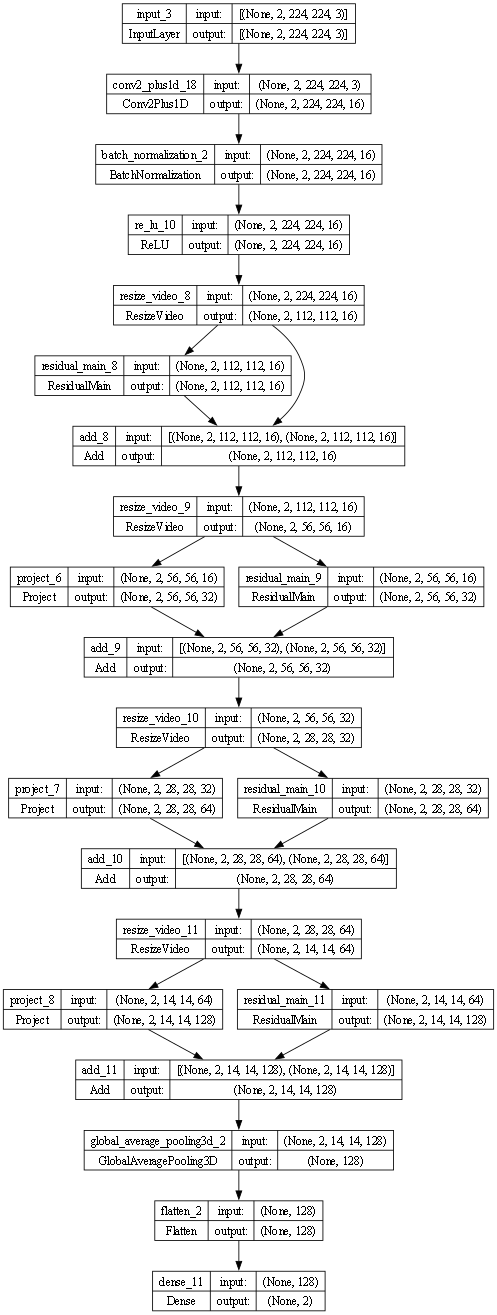

In [42]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True, to_file='modelvideoclass.png')

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [43]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 1e-3), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [44]:
history = model.fit(x = train_ds,
                    epochs = 11, 
                    validation_data = val_ds)

Epoch 1/11
8/8 [==============================] - 22s 2s/step - loss: 2.6088 - accuracy: 0.5500 - val_loss: 0.9915 - val_accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 15s 2s/step - loss: 0.4037 - accuracy: 0.7500 - val_loss: 0.6261 - val_accuracy: 0.7500
Epoch 3/11
8/8 [==============================] - 15s 2s/step - loss: 0.3766 - accuracy: 0.8500 - val_loss: 0.7627 - val_accuracy: 0.7500
Epoch 4/11
8/8 [==============================] - 15s 2s/step - loss: 0.3513 - accuracy: 0.9000 - val_loss: 1.0375 - val_accuracy: 0.6500
Epoch 5/11
8/8 [==============================] - 15s 2s/step - loss: 0.2742 - accuracy: 0.8667 - val_loss: 0.6985 - val_accuracy: 0.7500
Epoch 6/11
8/8 [==============================] - 15s 2s/step - loss: 1.0740 - accuracy: 0.7500 - val_loss: 0.7302 - val_accuracy: 0.7000
Epoch 7/11
8/8 [==============================] - 16s 2s/step - loss: 0.6596 - accuracy: 0.7167 - val_loss: 0.8491 - val_accuracy: 0.5500
Epoch 8/11
8/8 [==================

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8725 - loss: 0.5659

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8676 - loss: 0.5703

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8639 - loss: 0.5723

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8581 - loss: 0.5775

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8523 - loss: 0.5821

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8477 - loss: 0.5864

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8430 - loss: 0.5912

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - accuracy: 0.8393 - loss: 0.5953

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 995ms/step - accuracy: 0.8363 - loss: 0.5983

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 996ms/step - accuracy: 0.8338 - loss: 0.6005

20/38 ━━━━━━━━━━━━━━━━━━━━ 17s 990ms/step - accuracy: 0.8318 - loss: 0.6021

21/38 ━━━━━━━━━━━━━━━━━━━━ 16s 996ms/step - accuracy: 0.8296 - loss: 0.6038

22/38 ━━━━━━━━━━━━━━━━━━━━ 15s 998ms/step - accuracy: 0.8275 - loss: 0.6055

23/38 ━━━━━━━━━━━━━━━━━━━━ 14s 997ms/step - accuracy: 0.8258 - loss: 0.6077

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8244 - loss: 0.6093   

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8226 - loss: 0.6108

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8206 - loss: 0.6124

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8183 - loss: 0.6149

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8163 - loss: 0.6170

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8142 - loss: 0.6197 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8119 - loss: 0.6227

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8095 - loss: 0.6262

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8074 - loss: 0.6292

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8057 - loss: 0.6316

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8040 - loss: 0.6343

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8025 - loss: 0.6367

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8009 - loss: 0.6390

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7995 - loss: 0.6412

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7980 - loss: 0.6434

2024-05-01 01:58:10.789218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:58:10.789265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7966 - loss: 0.6455 - val_accuracy: 0.7100 - val_loss: 0.9882


Epoch 41/50


2024-05-01 01:58:21.393892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:58:21.393937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7500 - loss: 0.9852

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 932ms/step - accuracy: 0.7812 - loss: 0.8422

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7986 - loss: 0.7628   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8099 - loss: 0.7199

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8179 - loss: 0.6955

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1000ms/step - accuracy: 0.8135 - loss: 0.6886

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8070 - loss: 0.6827    

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 986ms/step - accuracy: 0.8038 - loss: 0.6749

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 988ms/step - accuracy: 0.7994 - loss: 0.6748

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 992ms/step - accuracy: 0.7982 - loss: 0.6711

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 989ms/step - accuracy: 0.7990 - loss: 0.6668

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 991ms/step - accuracy: 0.7984 - loss: 0.6645

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 985ms/step - accuracy: 0.7969 - loss: 0.6631

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1000ms/step - accuracy: 0.7954 - loss: 0.6622

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7952 - loss: 0.6591    

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7953 - loss: 0.6557

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7948 - loss: 0.6533

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7934 - loss: 0.6515

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7922 - loss: 0.6495

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7913 - loss: 0.6472

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7897 - loss: 0.6460

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7881 - loss: 0.6449

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7862 - loss: 0.6452

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7841 - loss: 0.6462

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7821 - loss: 0.6474

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7805 - loss: 0.6484

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7790 - loss: 0.6489

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7778 - loss: 0.6493

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7769 - loss: 0.6495 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7760 - loss: 0.6497

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7754 - loss: 0.6497

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7751 - loss: 0.6496

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7748 - loss: 0.6496

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7745 - loss: 0.6498

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7743 - loss: 0.6498

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7743 - loss: 0.6497

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7742 - loss: 0.6496

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7739 - loss: 0.6498

2024-05-01 01:58:59.493428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:58:59.493468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7736 - loss: 0.6500 - val_accuracy: 0.6400 - val_loss: 1.0812


Epoch 42/50


2024-05-01 01:59:10.000232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:59:10.000273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8750 - loss: 0.4154

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 920ms/step - accuracy: 0.8125 - loss: 0.4990

 3/38 ━━━━━━━━━━━━━━━━━━━━ 32s 938ms/step - accuracy: 0.8194 - loss: 0.5098

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 947ms/step - accuracy: 0.8255 - loss: 0.5166

 5/38 ━━━━━━━━━━━━━━━━━━━━ 31s 962ms/step - accuracy: 0.8304 - loss: 0.5145

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 994ms/step - accuracy: 0.8309 - loss: 0.5178

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 990ms/step - accuracy: 0.8347 - loss: 0.5173

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 992ms/step - accuracy: 0.8299 - loss: 0.5264

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 990ms/step - accuracy: 0.8257 - loss: 0.5341

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 977ms/step - accuracy: 0.8219 - loss: 0.5397

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 985ms/step - accuracy: 0.8195 - loss: 0.5431

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 996ms/step - accuracy: 0.8163 - loss: 0.5479

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8141 - loss: 0.5520   

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8127 - loss: 0.5548

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8119 - loss: 0.5562

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8110 - loss: 0.5576

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8100 - loss: 0.5592

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8086 - loss: 0.5615

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8069 - loss: 0.5640

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8043 - loss: 0.5688

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8023 - loss: 0.5728

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8005 - loss: 0.5767

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7990 - loss: 0.5800

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7980 - loss: 0.5823

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7971 - loss: 0.5847

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7962 - loss: 0.5867

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7952 - loss: 0.5892

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7940 - loss: 0.5917

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7933 - loss: 0.5937 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7927 - loss: 0.5952

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7918 - loss: 0.5973

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7912 - loss: 0.5990

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7906 - loss: 0.6013

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7901 - loss: 0.6033

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7898 - loss: 0.6051

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7894 - loss: 0.6072

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7888 - loss: 0.6093

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.7882 - loss: 0.6113

2024-05-01 01:59:47.954600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:59:47.954645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7876 - loss: 0.6132 - val_accuracy: 0.6500 - val_loss: 0.9893


Epoch 43/50


2024-05-01 01:59:58.264155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 01:59:58.264208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 1.0000 - loss: 0.3052

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9375 - loss: 0.4867

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9306 - loss: 0.5178

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9089 - loss: 0.5485

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8921 - loss: 0.5788

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8753 - loss: 0.6200

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8651 - loss: 0.6408

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8566 - loss: 0.6560

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8463 - loss: 0.6757

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8366 - loss: 0.6902

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8288 - loss: 0.6996

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8205 - loss: 0.7093

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8121 - loss: 0.7184

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8057 - loss: 0.7241

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8009 - loss: 0.7276

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7963 - loss: 0.7300

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7922 - loss: 0.7311

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7876 - loss: 0.7346

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7835 - loss: 0.7372

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7800 - loss: 0.7390

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7768 - loss: 0.7399

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7743 - loss: 0.7404

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7721 - loss: 0.7416

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7703 - loss: 0.7429

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7685 - loss: 0.7441

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7669 - loss: 0.7450

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7652 - loss: 0.7457

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7637 - loss: 0.7464

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7626 - loss: 0.7466 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7617 - loss: 0.7465

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7608 - loss: 0.7463

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7601 - loss: 0.7459

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7594 - loss: 0.7454

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7588 - loss: 0.7447

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7583 - loss: 0.7438

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7576 - loss: 0.7432

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7571 - loss: 0.7427

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.7566 - loss: 0.7420

2024-05-01 02:00:36.047747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:00:36.047794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7562 - loss: 0.7414 - val_accuracy: 0.6400 - val_loss: 0.9363


Epoch 44/50


2024-05-01 02:00:46.694517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:00:46.694561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 0.2602

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 949ms/step - accuracy: 1.0000 - loss: 0.3181

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 989ms/step - accuracy: 0.9583 - loss: 0.3698

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9453 - loss: 0.3915   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9413 - loss: 0.4036

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9372 - loss: 0.4178

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9334 - loss: 0.4313

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9300 - loss: 0.4417

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9223 - loss: 0.4578

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9163 - loss: 0.4720

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9105 - loss: 0.4835

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9058 - loss: 0.4924

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9020 - loss: 0.4999

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8988 - loss: 0.5051

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8950 - loss: 0.5103

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8913 - loss: 0.5143

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8869 - loss: 0.5199

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8835 - loss: 0.5241

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8810 - loss: 0.5274

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8782 - loss: 0.5317

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8758 - loss: 0.5359

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8734 - loss: 0.5396

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8709 - loss: 0.5432

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8689 - loss: 0.5461

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8669 - loss: 0.5489

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8646 - loss: 0.5523

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8628 - loss: 0.5548

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8610 - loss: 0.5574

29/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1000ms/step - accuracy: 0.8594 - loss: 0.5597

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8580 - loss: 0.5618    

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8567 - loss: 0.5636

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8553 - loss: 0.5652

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8540 - loss: 0.5669

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8527 - loss: 0.5683

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8516 - loss: 0.5696

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8506 - loss: 0.5710

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8495 - loss: 0.5724

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8485 - loss: 0.5736

2024-05-01 02:01:24.638701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:01:24.638744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8476 - loss: 0.5748 - val_accuracy: 0.6500 - val_loss: 1.0424


Epoch 45/50


2024-05-01 02:01:35.172700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:01:35.172746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6250 - loss: 0.6166

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6562 - loss: 0.6917

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6597 - loss: 0.7025

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6589 - loss: 0.7113

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6721 - loss: 0.6988

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6851 - loss: 0.6814

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6943 - loss: 0.6645

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6993 - loss: 0.6632

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7034 - loss: 0.6631

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7068 - loss: 0.6647

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7108 - loss: 0.6642

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7140 - loss: 0.6634

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7168 - loss: 0.6636

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7198 - loss: 0.6629

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7229 - loss: 0.6614

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7266 - loss: 0.6588

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7297 - loss: 0.6564

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7331 - loss: 0.6532

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7364 - loss: 0.6494

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7387 - loss: 0.6468

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7406 - loss: 0.6445

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7424 - loss: 0.6429

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7441 - loss: 0.6412

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7461 - loss: 0.6390

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7476 - loss: 0.6374

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7487 - loss: 0.6363

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7497 - loss: 0.6349

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7510 - loss: 0.6334

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7523 - loss: 0.6317 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7536 - loss: 0.6299

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7549 - loss: 0.6280

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7561 - loss: 0.6263

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7573 - loss: 0.6245

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7584 - loss: 0.6230

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7594 - loss: 0.6215

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7605 - loss: 0.6199

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7613 - loss: 0.6188

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.7621 - loss: 0.6177

2024-05-01 02:02:13.523955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:02:13.523997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7629 - loss: 0.6167 - val_accuracy: 0.6500 - val_loss: 0.9271


Epoch 46/50


2024-05-01 02:02:23.865125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:02:23.865184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7500 - loss: 0.6142

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 940ms/step - accuracy: 0.7500 - loss: 0.6054

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 953ms/step - accuracy: 0.7361 - loss: 0.6379

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 971ms/step - accuracy: 0.7474 - loss: 0.6236

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 984ms/step - accuracy: 0.7529 - loss: 0.6094

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 980ms/step - accuracy: 0.7559 - loss: 0.6020

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 972ms/step - accuracy: 0.7602 - loss: 0.5928

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 983ms/step - accuracy: 0.7667 - loss: 0.5811

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 995ms/step - accuracy: 0.7710 - loss: 0.5720

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1000ms/step - accuracy: 0.7752 - loss: 0.5654

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 985ms/step - accuracy: 0.7791 - loss: 0.5588 

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 987ms/step - accuracy: 0.7836 - loss: 0.5516

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 988ms/step - accuracy: 0.7862 - loss: 0.5488

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 984ms/step - accuracy: 0.7881 - loss: 0.5465

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 991ms/step - accuracy: 0.7889 - loss: 0.5448

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 997ms/step - accuracy: 0.7884 - loss: 0.5445

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.7879 - loss: 0.5443

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 997ms/step - accuracy: 0.7877 - loss: 0.5436

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7874 - loss: 0.5434   

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7874 - loss: 0.5436

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7879 - loss: 0.5431

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7883 - loss: 0.5425

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7887 - loss: 0.5417

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7886 - loss: 0.5417

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7885 - loss: 0.5416

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7885 - loss: 0.5417

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7888 - loss: 0.5417

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7893 - loss: 0.5416

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7899 - loss: 0.5414 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7906 - loss: 0.5410

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7915 - loss: 0.5404

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7921 - loss: 0.5407

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7925 - loss: 0.5414

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7930 - loss: 0.5419

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7932 - loss: 0.5426

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7934 - loss: 0.5432

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7935 - loss: 0.5442

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.7935 - loss: 0.5451

2024-05-01 02:03:01.694907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:03:01.694956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7934 - loss: 0.5460 - val_accuracy: 0.6700 - val_loss: 0.9752


Epoch 47/50


2024-05-01 02:03:11.908832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:03:11.908875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 36s 985ms/step - accuracy: 0.5000 - loss: 1.1843

 2/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5938 - loss: 1.0711   

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6319 - loss: 0.9817

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6693 - loss: 0.9152

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 987ms/step - accuracy: 0.7004 - loss: 0.8583

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7226 - loss: 0.8147   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7418 - loss: 0.7784

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7545 - loss: 0.7516

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7664 - loss: 0.7278

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7735 - loss: 0.7086

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7796 - loss: 0.6925

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7850 - loss: 0.6789

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7904 - loss: 0.6657

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7939 - loss: 0.6560

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7954 - loss: 0.6501

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 998ms/step - accuracy: 0.7975 - loss: 0.6441

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - accuracy: 0.7994 - loss: 0.6383

18/38 ━━━━━━━━━━━━━━━━━━━━ 19s 992ms/step - accuracy: 0.8009 - loss: 0.6337

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 987ms/step - accuracy: 0.8021 - loss: 0.6295

20/38 ━━━━━━━━━━━━━━━━━━━━ 17s 994ms/step - accuracy: 0.8029 - loss: 0.6256

21/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1000ms/step - accuracy: 0.8035 - loss: 0.6226

22/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1000ms/step - accuracy: 0.8044 - loss: 0.6194

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8049 - loss: 0.6176    

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8056 - loss: 0.6155

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8064 - loss: 0.6133

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8072 - loss: 0.6112

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8082 - loss: 0.6089

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8090 - loss: 0.6071

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8098 - loss: 0.6051 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8103 - loss: 0.6033

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8108 - loss: 0.6018

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8112 - loss: 0.6003

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8118 - loss: 0.5988

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8122 - loss: 0.5974

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8124 - loss: 0.5967

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8126 - loss: 0.5960

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8128 - loss: 0.5952

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.8130 - loss: 0.5944

2024-05-01 02:03:49.848870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:03:49.848917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8132 - loss: 0.5937 - val_accuracy: 0.6700 - val_loss: 0.9059


Epoch 48/50


2024-05-01 02:04:00.126769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:04:00.126860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.1455

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9062 - loss: 0.3339

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8681 - loss: 0.4143

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8464 - loss: 0.4486

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8421 - loss: 0.4608

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8441 - loss: 0.4652

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8460 - loss: 0.4676

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8476 - loss: 0.4698

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8507 - loss: 0.4709

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8494 - loss: 0.4766

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8455 - loss: 0.4845

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8427 - loss: 0.4913

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8400 - loss: 0.4992

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8387 - loss: 0.5046

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8372 - loss: 0.5093

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8357 - loss: 0.5144

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8337 - loss: 0.5191

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8321 - loss: 0.5232

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8313 - loss: 0.5255

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8310 - loss: 0.5270

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8308 - loss: 0.5281

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8300 - loss: 0.5295

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8295 - loss: 0.5302

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8286 - loss: 0.5319

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8279 - loss: 0.5329

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8273 - loss: 0.5336

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8268 - loss: 0.5342

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8266 - loss: 0.5343

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8265 - loss: 0.5343 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8260 - loss: 0.5353

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8257 - loss: 0.5359

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8251 - loss: 0.5368

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8246 - loss: 0.5377

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8242 - loss: 0.5383

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8237 - loss: 0.5392

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8233 - loss: 0.5401

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8231 - loss: 0.5407

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.8228 - loss: 0.5414

2024-05-01 02:04:37.949920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:04:37.949995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8226 - loss: 0.5420 - val_accuracy: 0.6800 - val_loss: 0.9071


Epoch 49/50


2024-05-01 02:04:48.384197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:04:48.384267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8750 - loss: 0.4895

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 961ms/step - accuracy: 0.9062 - loss: 0.4467

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9097 - loss: 0.4724   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 956ms/step - accuracy: 0.9089 - loss: 0.4784

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 988ms/step - accuracy: 0.9021 - loss: 0.4926

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 988ms/step - accuracy: 0.9010 - loss: 0.4997

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 974ms/step - accuracy: 0.8999 - loss: 0.5011

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 973ms/step - accuracy: 0.8987 - loss: 0.5020

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 977ms/step - accuracy: 0.8976 - loss: 0.5065

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 974ms/step - accuracy: 0.8979 - loss: 0.5070

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 992ms/step - accuracy: 0.8958 - loss: 0.5101

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 995ms/step - accuracy: 0.8941 - loss: 0.5119

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8933 - loss: 0.5113   

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 997ms/step - accuracy: 0.8933 - loss: 0.5109

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 995ms/step - accuracy: 0.8926 - loss: 0.5130

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8920 - loss: 0.5139   

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8910 - loss: 0.5152

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8897 - loss: 0.5160

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8890 - loss: 0.5161

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8880 - loss: 0.5164

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8871 - loss: 0.5167

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8862 - loss: 0.5170

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8855 - loss: 0.5175

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8846 - loss: 0.5180

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8839 - loss: 0.5183

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8832 - loss: 0.5186

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8827 - loss: 0.5186

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8822 - loss: 0.5186

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8817 - loss: 0.5190 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8813 - loss: 0.5189

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8811 - loss: 0.5186

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8811 - loss: 0.5183

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8810 - loss: 0.5180

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8807 - loss: 0.5178

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8803 - loss: 0.5175

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8801 - loss: 0.5172

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8799 - loss: 0.5169

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.8797 - loss: 0.5166

2024-05-01 02:05:26.346920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:05:26.346961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8795 - loss: 0.5163 - val_accuracy: 0.6600 - val_loss: 1.0068


Epoch 50/50


2024-05-01 02:05:36.808373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:05:36.808415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 1.0000 - loss: 0.4015

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9688 - loss: 0.4374

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9375 - loss: 0.4850

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9219 - loss: 0.4997

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9125 - loss: 0.5024

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9028 - loss: 0.4998

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8963 - loss: 0.5021

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8838 - loss: 0.5150

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8736 - loss: 0.5254

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8650 - loss: 0.5333

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8576 - loss: 0.5395

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8521 - loss: 0.5426

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8480 - loss: 0.5457

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8435 - loss: 0.5507

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8406 - loss: 0.5532

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8389 - loss: 0.5549

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8375 - loss: 0.5559

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8369 - loss: 0.5555

19/38 ━━━━━━━━━━━━━━━━━━━━ 18s 999ms/step - accuracy: 0.8361 - loss: 0.5560

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8356 - loss: 0.5559   

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8352 - loss: 0.5559

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8352 - loss: 0.5555

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8353 - loss: 0.5548

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8354 - loss: 0.5538

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8354 - loss: 0.5530

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8354 - loss: 0.5523

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8357 - loss: 0.5513

28/38 ━━━━━━━━━━━━━━━━━━━━ 9s 998ms/step - accuracy: 0.8355 - loss: 0.5515

29/38 ━━━━━━━━━━━━━━━━━━━━ 8s 994ms/step - accuracy: 0.8354 - loss: 0.5516

30/38 ━━━━━━━━━━━━━━━━━━━━ 7s 992ms/step - accuracy: 0.8350 - loss: 0.5520

31/38 ━━━━━━━━━━━━━━━━━━━━ 6s 996ms/step - accuracy: 0.8348 - loss: 0.5522

32/38 ━━━━━━━━━━━━━━━━━━━━ 5s 999ms/step - accuracy: 0.8347 - loss: 0.5523

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8346 - loss: 0.5527   

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8345 - loss: 0.5532

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8342 - loss: 0.5540

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8338 - loss: 0.5550

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8334 - loss: 0.5560

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8331 - loss: 0.5567

2024-05-01 02:06:14.573998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:06:14.574044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8329 - loss: 0.5575 - val_accuracy: 0.6900 - val_loss: 0.8807


2024-05-01 02:06:24.815809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-01 02:06:24.815853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

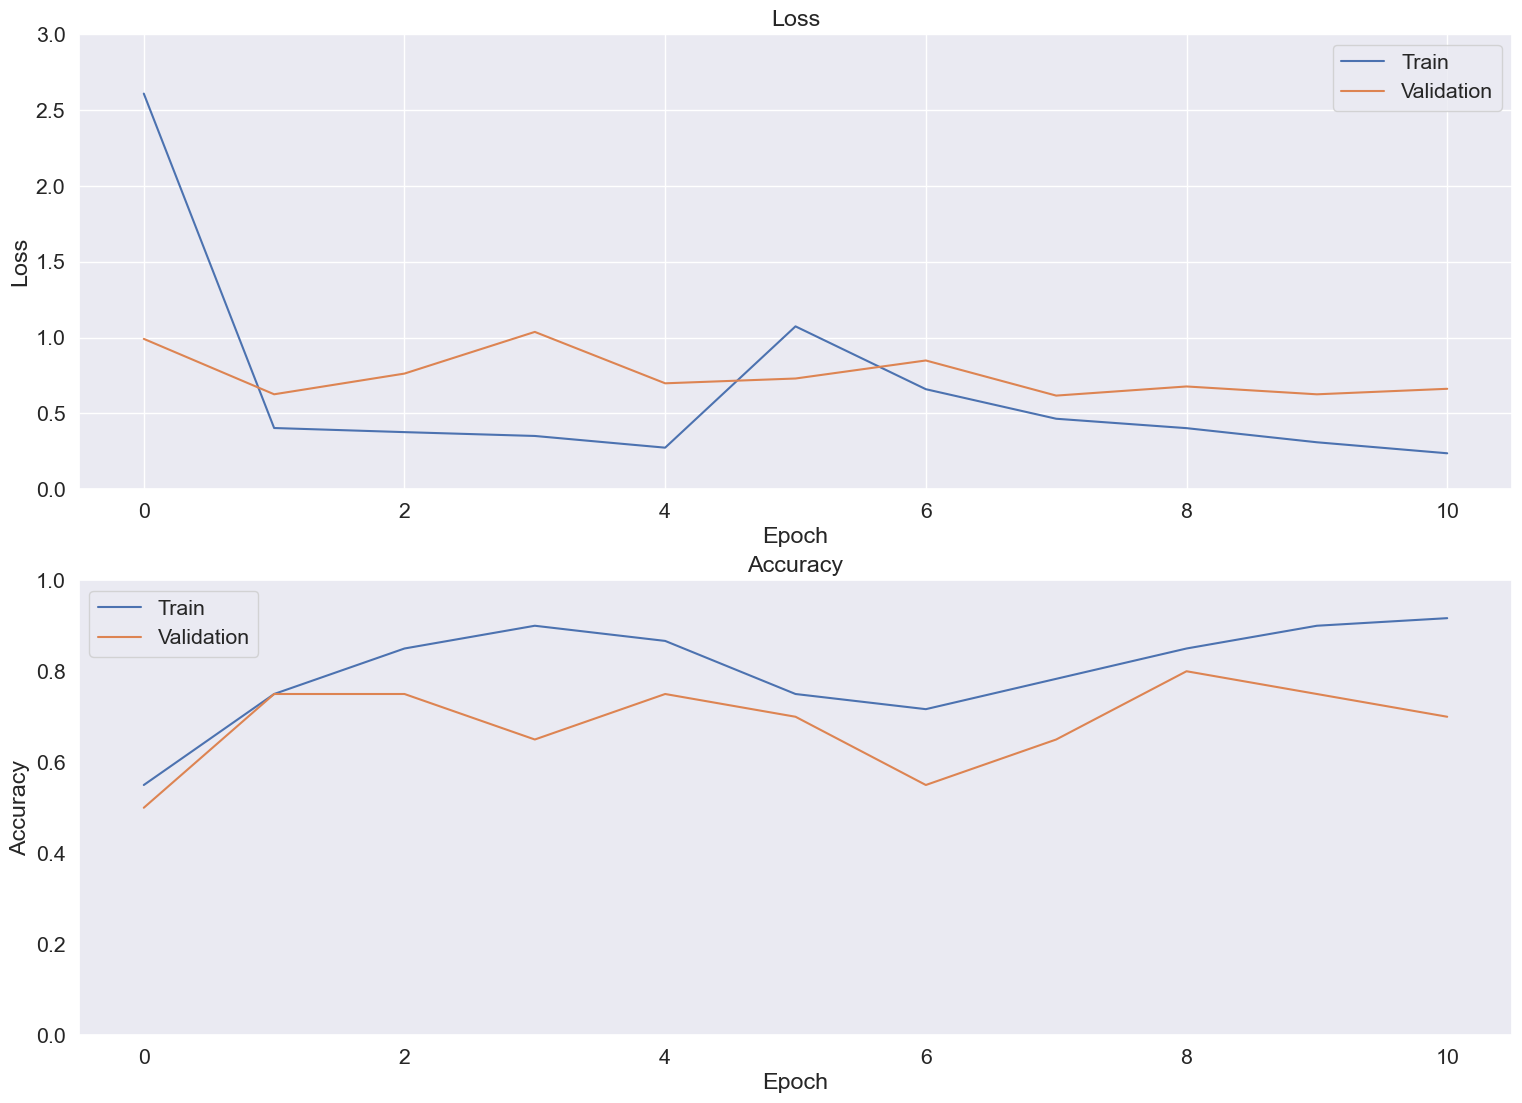

In [60]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 13)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.grid()
  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [46]:
model.evaluate(test_ds, return_dict=True)

3/3 [==============================] - 2s 487ms/step - loss: 0.3192 - accuracy: 0.8000


{'loss': 0.31916671991348267, 'accuracy': 0.800000011920929}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [47]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [48]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(4, 4)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [49]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

8/8 [==============================] - 7s 717ms/step


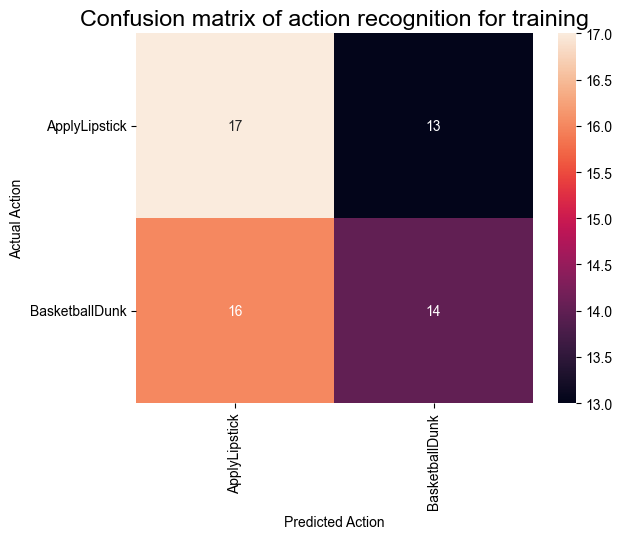

     19/Unknown 17s 792ms/step

     20/Unknown 18s 789ms/step

     21/Unknown 19s 788ms/step

     22/Unknown 19s 789ms/step

     23/Unknown 20s 787ms/step

     24/Unknown 21s 788ms/step

     25/Unknown 22s 796ms/step

     26/Unknown 23s 798ms/step

     27/Unknown 24s 801ms/step

     28/Unknown 24s 803ms/step

     29/Unknown 25s 802ms/step

     30/Unknown 26s 807ms/step

     31/Unknown 27s 808ms/step

     32/Unknown 28s 810ms/step

     33/Unknown 29s 813ms/step

     34/Unknown 30s 817ms/step

     35/Unknown 31s 817ms/step

     36/Unknown 32s 821ms/step

     37/Unknown 33s 825ms/step

     38/Unknown 35s 867ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 867ms/step


2024-05-01 02:07:39.707651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


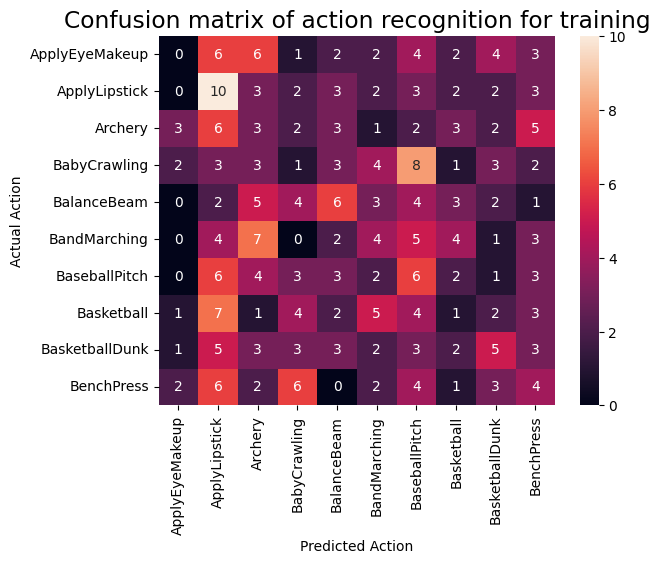

In [50]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

3/3 [==============================] - 2s 468ms/step


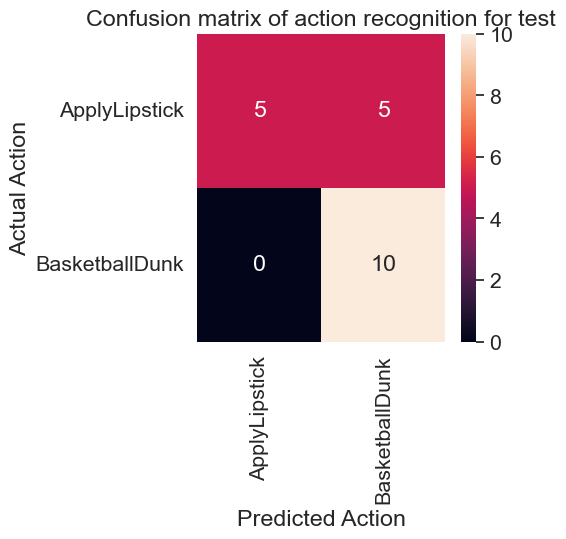

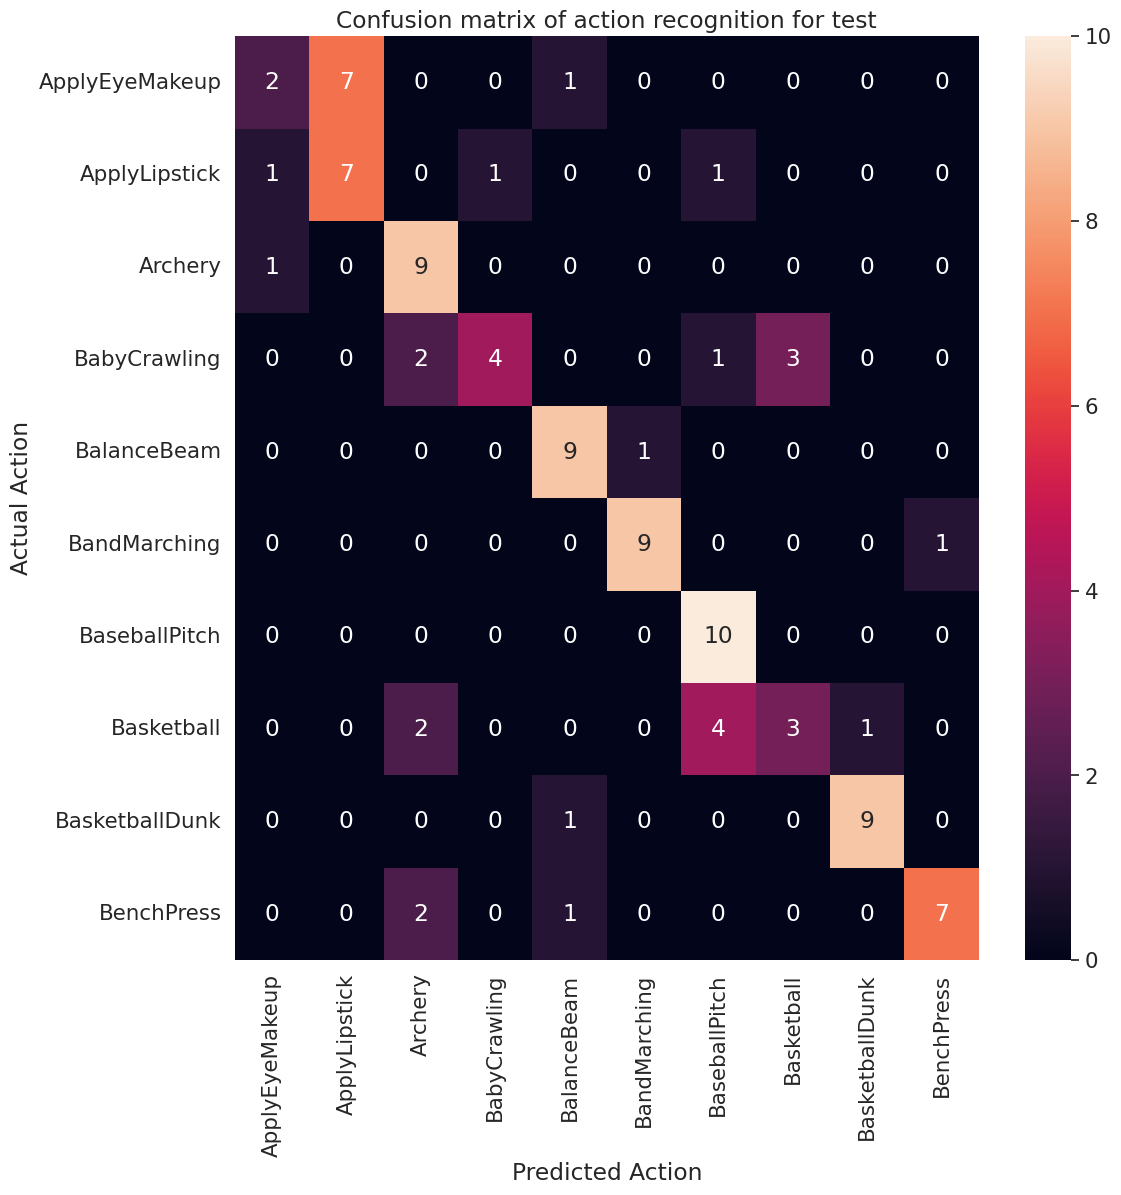

In [51]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [52]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [53]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [54]:
precision

{'ApplyLipstick': 1.0, 'BasketballDunk': 0.6666666666666666}

In [55]:
recall

{'ApplyLipstick': 0.5, 'BasketballDunk': 1.0}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)